# Herron - Do market prices respond to new information?

This notebook uses [Elon Musk's proposed acquisition of Twitter (TWTR)](https://en.wikipedia.org/wiki/Proposed_acquisition_of_Twitter_by_Elon_Musk) to show that market prices respond to information.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')
import yfinance as yf
import pandas_datareader as pdr

## Dates and Data

In [4]:
dates = {
    'First Purchase': pd.to_datetime('2022-01-31'),
    'Purchases Announced': pd.to_datetime('2022-04-04'),
    'Bid Announced': pd.to_datetime('2022-04-14'),
    # 'Funding Secured': pd.to_datetime('2022-04-20'),
    'Bid "on Hold"': pd.to_datetime('2022-05-13'),
    'Bid Revived': pd.to_datetime('2022-10-04'),
    'Deal Complete': pd.to_datetime('2022-10-27'),
}

In [5]:
price_bid = 54.20

In [6]:
twtr_all = yf.download(tickers='TWTR', session=session, ignore_tz=False)

[*********************100%***********************]  1 of 1 completed


## Implied Probability of Deal Completion

Twitter's stock price is the present value of expected cash flows.
If the deal closes, the expected cash flow is the bid price.
Otherwise, the expected cash flow is the unaffected price.
So, $$P_{t} = p_t \times P_{bid} + (1-p_t) \times P_{unaffected},$$ where $p$ is the implied probability of deal completion and $P$s are share prices.
We can rearrange this formula to estimate an implied probability of deal completion as $$p_t = \frac{P_t - P_{unaffected}}{P_{bid} - P_{unaffected}}.$$
We can organize this formula as $$p_t = \frac{P_t}{P_{bid} - P_{unaffected}} - \frac{P_{unaffected}}{P_{bid} - P_{unaffected}},$$ so the implied probability of deal completion, for a cash deal, is a multiple of the share price minus a constant.

We will add a `Price` column to make our code easier to read and compare to the formulas above.

In [7]:
twtr_all['Price'] = twtr_all['Close']

We will assume the unnaffected price is the price 20 business days before Musk announced his share purchases.

In [8]:
price_unaffected = twtr_all.loc[dates['Purchases Announced'] - pd.offsets.BDay(20), 'Price']

We will use the formula above to estimate the implied probability of deal completion.

In [9]:
twtr_all['Probability'] = (twtr_all['Price'] - price_unaffected) / (price_bid - price_unaffected)

However, the probability of deal completion is defined for dates on or after the bid announcement.
We step back one business day with `pd.offsets.BDay(1)` because string and date ranges are inclusive on both ends with pandas.

In [10]:
twtr_all.loc[:dates['Bid Announced'] - pd.offsets.BDay(1), 'Probability'] = np.nan

To avoid excessive `.loc[]` statements, we will slice `twtr_all` to the relevant date range and columns in `twtr`.

In [11]:
twtr = twtr_all.loc[dates['First Purchase']:,  ['Price', 'Probability']]

## Plots of Prices, Probabilities, and Events

When I plot multiple, disparate series (i.e., multiple columns in the same pandas data frame), I typically use the `subplots=True` argument to plot one series per panel.
One series per panel is typically easier to interpret than two y axes and avoids misleading your audience (or your audience feeling mislead).

Why does probability never get to 100%?

1. Deal is still not certain to close/complete
1. Our $P_{bid}$ estimate will not be the final price
1. Our $P_{unaffected}$ estiamte will not be where the price goes if deal does not close

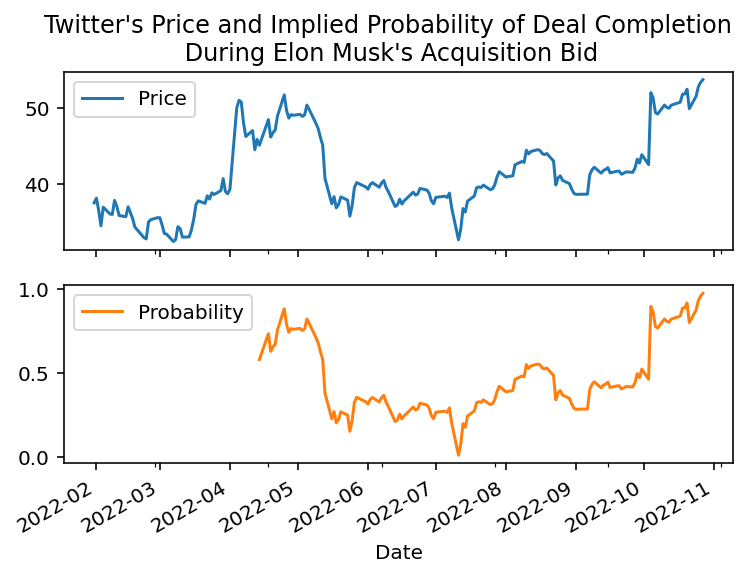

In [12]:
twtr.plot(subplots=True)
plt.suptitle('Twitter\'s Price and Implied Probability of Deal Completion\n During Elon Musk\'s Acquisition Bid')
plt.show()

Finally, we can iterate over our dictionary of dates to quickly annotate our plot of TWTR prices.
If we want to precisely place annotations, we need to either manually place them or write a more complicated loop.

In [13]:
list(dates.keys())[-2:]

['Bid Revived', 'Deal Complete']

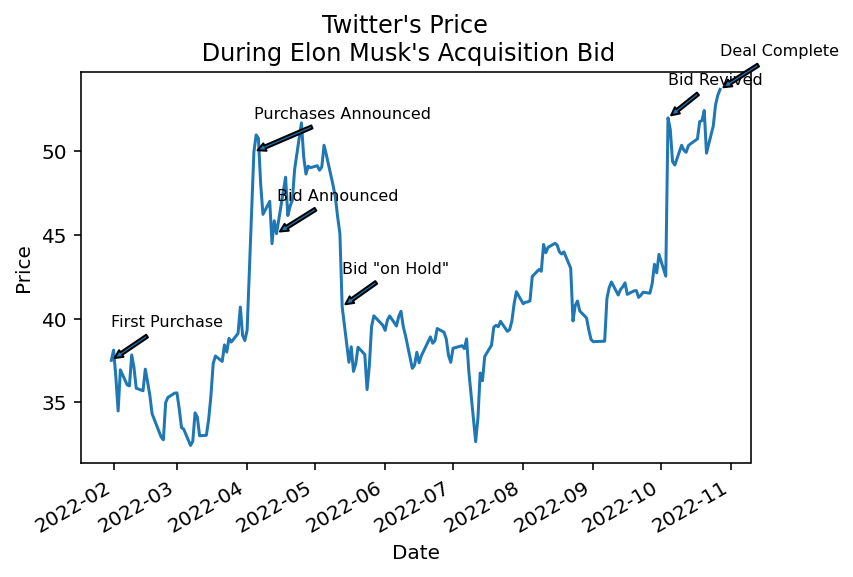

In [14]:
twtr['Price'].plot()

for label, date in dates.items():
    price = twtr.loc[date, 'Price']
    date_offset = pd.offsets.BDay(0) # pd.offsets.BDay(0 if label != 'Bid Revived' else -30)
    price_offset = 2 # 2 if label not in list(dates.keys())[-2:] else -2.5
    plt.annotate(
        text=label,
        fontsize=8,
        xy=(date, price),
        xytext=(date + date_offset, price + price_offset),
        arrowprops={
            'arrowstyle': 'simple'
        }
    )

plt.ylabel('Price')
plt.suptitle('Twitter\'s Price\n During Elon Musk\'s Acquisition Bid')
plt.show()

The above plot is a good start!
If you wanted a specific look, you would need to really dig into the docstrings for `.plot()` and `plt.annotate()`!